# ltu-ili evidence estimation
This is a tutorial for using ltu-ili evidence networks in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## Generate model

In [2]:
N = 5
n_params = N
ystd = np.sqrt(0.001*N)*np.linspace(2.5,4., N)**2.
x = np.linspace(0,np.pi/2,N)

In [3]:

from scipy.stats import norm, multivariate_normal

def mu_data(x, theta, mat_A=None):
    """
    Calculate data mean as function of parameters: $\mu(\theta)$
    :param x: data coordinates x
    :param theta: model parameters $\theta$
    :param mat_A: matrix $A_{ij}$ for linear model
    :return: mean data vector $\mu(\theta)$
    """
    theta = np.array(theta)
    if mat_A is None:
        mat_A = matrix_operation(np.array(x), theta.shape[-1])
    return np.inner(mat_A, theta)

def coordinate_function(x, j):
    """
    Defines function for linear model matrix: $A_{ij}=f_j(x_i)$
    :param x: data coordinates x
    :param j: parameter index corresponding to: $\theta_j$
    :return: f(x,j) = cos(x * (j + 1/2))
    """
    return np.cos((j - 0.5) * x)

def matrix_operation(x, n_params):
    """
    Generate matrix $A_{ij}$ for linear model
    :param x: data coordinates x
    :param n_params: number of parameters in $\theta$
    :return: matrix $A_{ij}$
    """
    mat_A = np.ones((x.shape[0], n_params))
    for j in np.arange(n_params):
        if j>0:
            mat_A[:, j] = coordinate_function(x, j)
        else:
            mat_A[:, j] = x * 2.
    return mat_A

def evidence_analytic(y, mat_A, mu_prior, cov_prior, cov_data):
    """
    Analytic evidence calculation for model
    :param y: noisy data y
    :param mat_A: matrix $A_{ij}$ for linear model
    :param mu_prior:  prior mean for parameters
    :param cov_prior: prior covariance for parameters
    :param cov_data:  data covariance
    :return:
    """
    mu_evidence = np.dot(mat_A, np.array(mu_prior))
    cov_evidence = np.dot(np.dot(mat_A, np.array(cov_prior)),
                          mat_A.T) + cov_data
    return multivariate_normal.pdf(y, mean=mu_evidence, cov=cov_evidence)

def bayes_factor_theta_0(y, x, n_params, ystd):
    """
    Bayes factor calculation for nested model without $\theta{j=0}=0$
    (logK > 0 implies $\theta_0=0$ is disfavoured)
    :param y: noisy data y
    :param x: data coordinates x
    :param n_params: number of parameters in $\theta$
    :param ystd: standard deviation of data: $\sqrt(\diag(Cov))$
    :return: Bayes factor
    """
    baseline_evidence = evidence_analytic(y, matrix_operation(x, n_params), np.zeros(n_params),
                                          np.identity(n_params), np.identity(len(ystd)) * ystd ** 2)

    alternative_evidence = evidence_analytic(y, matrix_operation(x, n_params)[:, 1:], np.zeros(n_params)[1:],
                                             np.identity(n_params)[1:, 1:], np.identity(len(ystd)) * ystd ** 2)

    return baseline_evidence / alternative_evidence

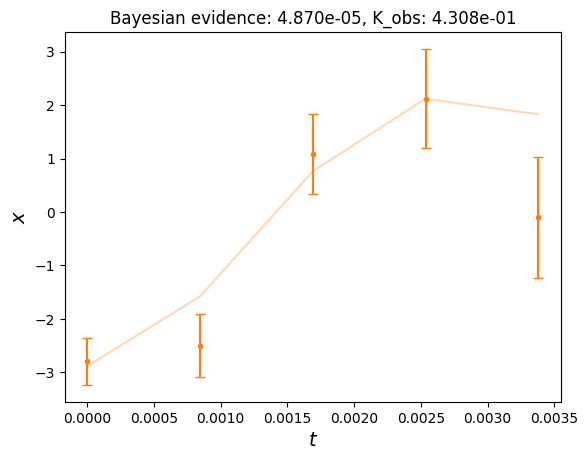

In [48]:
theta_true = np.random.normal(size=(n_params))
mu_true = mu_data(x, theta_true)
y_obs = np.random.normal(mu_true, ystd)

evidence_y = evidence_analytic(
    y_obs, matrix_operation(x, n_params), np.zeros(n_params),
    np.identity(n_params), np.identity(len(ystd)) * ystd**2)
K_obs = bayes_factor_theta_0(y_obs, x, n_params, ystd)

plt.plot(x*0.5*np.pi*0.5/365., mu_true, c='C1' , alpha=0.3)
plt.errorbar(x*0.5*np.pi*0.5/365., y_obs, yerr=ystd, fmt='.C1', capsize=3.45)
plt.xlabel(r'$t$', fontsize=14),plt.ylabel(r'$x$', fontsize=14)
plt.title(f"Bayesian evidence: {evidence_y:.3e}, K_obs: {K_obs:.3e}");

In [90]:
# Generate data
Nexamples = 10000
prior_mu1, prior_std1 = 0., 1.
prior_mu2, prior_std2 = 0., 0.1

theta1 = np.random.normal(prior_mu1, prior_std1, size=(Nexamples, n_params))
theta2 = np.random.normal(prior_mu2, prior_std2, size=(Nexamples, n_params))

mu1 = mu_data(x, theta1).T
mu2 = mu_data(x, theta2).T

y1 = np.random.normal(mu1, ystd)
y2 = np.random.normal(mu2, ystd)

loader1 = NumpyLoader(x=y1, theta=theta1)
loader2 = NumpyLoader(x=y2, theta=theta2)

## Harmonic Estimator (Evidence)

In [96]:
## Setup the inference runner

# define a prior
prior = ili.utils.IndependentNormal(
    loc=prior_mu1*np.ones(n_params),
    scale=prior_std1*np.ones(n_params),
    device=device
)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [97]:
# train the model
posterior_ensemble, summaries = runner(loader=loader1)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 141

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 85 142 epochs.

INFO:root:It took 146.29007840156555 seconds to train models.


 Neural network successfully converged after 86 epochs.

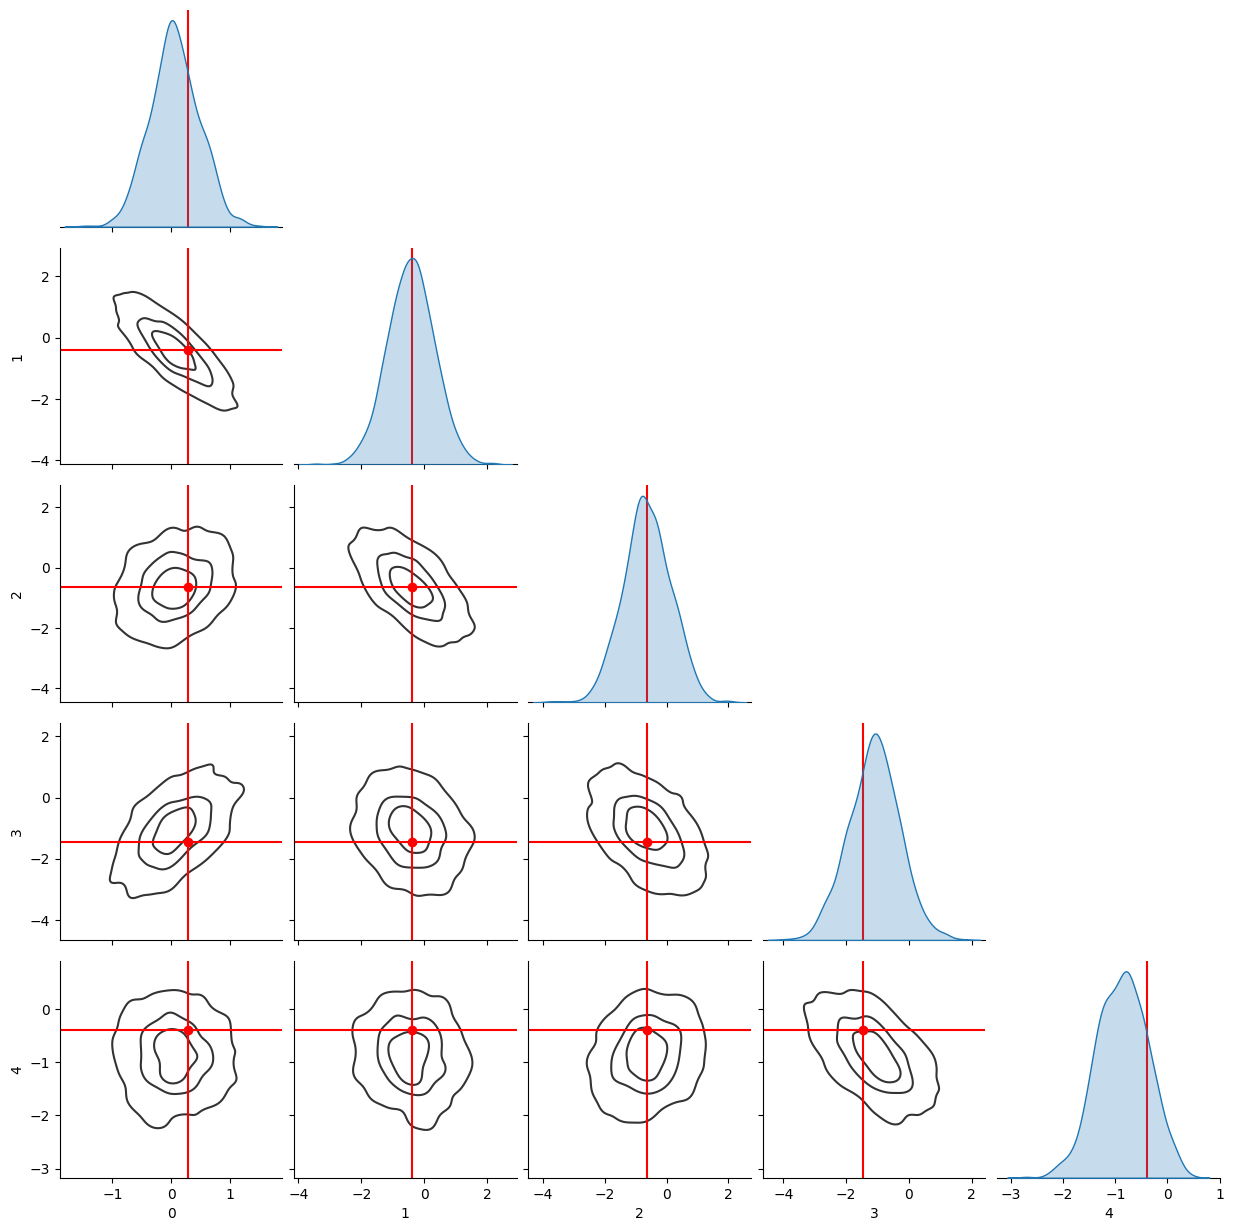

In [98]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct'
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = y_obs, theta_fid=theta_true,
    show_progress_bars=False
)

In [99]:
from ili.evidence import HarmonicEvidence

estimator = HarmonicEvidence()

In [100]:
ln_inv_evidence, err_ln_inv_evidence = estimator.from_posterior(
    posterior_ensemble, x=y_obs,
    shape=(100_000,),
    show_progress_bars=False
)

Training NF: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


In [104]:
print(f'Predicted ln(evidence) = {-ln_inv_evidence} +/- {err_ln_inv_evidence}')
print(f'True ln(evidence) = {np.log(evidence_y)}')

Predicted ln(evidence) = 0.023742377758026123 +/- (-0.0025410327246129273, 0.002534592239332582)
True ln(evidence) = -9.929773614843704


## Evidence Networks (Bayes Factor)

In [105]:
from ili.evidence import K_EvidenceNetwork

runner = K_EvidenceNetwork(
    layer_width=32, added_layers=3,
    batch_norm_flag=1, alpha=2,
    train_args=dict(max_epochs=100, lr=5e-5)
)

In [106]:
summary = runner.train(loader1, loader2)

42 epochs [00:09,  4.50 epochs/s, loss1=-9.51e-5, loss_val1=0.000428]


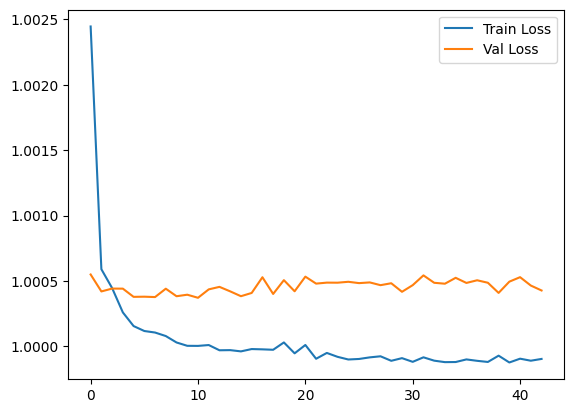

In [107]:
plt.plot(summary['training_loss'], label='Train Loss')
plt.plot(summary['validation_loss'], label='Val Loss')
plt.legend()

In [109]:
logK = runner.predict(y_obs).detach().numpy()[0]
print(f'Predicted lnK: {logK[0]}')
print(f'True lnK: {np.log(K_obs)}')

Predicted lnK: -0.034155916422605515
True lnK: -0.842116162086123
